In [5]:
import networkx as nx
from copy import deepcopy

In [6]:
fh = open("test.edgelist", "rb")
G = nx.read_edgelist(fh, nodetype=int)
fh.close()

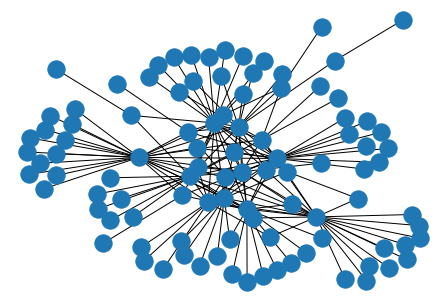

In [14]:
nx.draw_networkx(G)

In [ ]:
sp = nx.shortest_path(G,weight=delay)

In [ ]:
import random
node_cnt = 100
flow_cnt = 0
of = open("test.flowlist", "w")
# store remaining bandwith of the link
band_rem = {}
link_bandwidth_const = 10000.0
max_try = 100000
for _ in range(G.number_of_edges()*2*200):
    # gen source
    src = random.randint(0,node_cnt - 1)
    # gen destination
    dst = random.randint(0,node_cnt - 1)
    # throw illegal flow
    if dst == src:
        continue
    # gen period
    period = random.uniform(0.0025,0.0095)
    # gen packet size
    size = random.uniform(0.025,0.095)
    # cal bandwidth
    bandwidth = size / period
    # resolve a path
    # only shortest path
    paths = sp[str(src)][str(dst)]
    path_cnt = (len(paths) -1)
    # check if all the links on the path have enough bandwidth
    can_alloc = True
    which_link_cant = set()
    path_res = []
    for i in range(path_cnt):
        p = 's_'+paths[i]+'->'+paths[i+1]
        if p not in band_rem:
            band_rem[p] = link_bandwidth_const
        if band_rem[p] - bandwidth < 0.0:
            can_alloc = False
            which_link_cant.add(p)
    if can_alloc:
        # shortest path can fullfill the requirment
        # print('use shortest path')
        for i in range(path_cnt):
            p = 's_'+paths[i]+'->'+paths[i+1]
            band_rem[p] -= bandwidth
            path_res.append(p)
    else:
        # need to find a new path
        print('finding alternative path: '+str(src) + ' -> ' + str(dst))
        optional_paths = nx.all_simple_paths(G, str(src), str(dst))
        # print('total alternatives : ' + len(optional_paths))
        found_one = False
        try_cnt = 0
        for opath in optional_paths:
            can_use = True
            print(str(try_cnt)+'th try')
            # print(opath)
            for i in range(len(opath) - 1):
                 p = 's_'+opath[i]+'->'+opath[i+1]
                 if p in which_link_cant:
                     can_use = False
                     break
                 if p not in band_rem:
                     band_rem[p] = link_bandwidth_const
                 tmp = band_rem[p] - bandwidth
                 if tmp < 0.0:
                     print(p)
                     print(band_rem[p])
                     print(tmp)
                     can_use = False
                     break
            if can_use:
                found_one = True
                for i in range(len(opath) - 1):
                    p = 's_'+opath[i]+'->'+opath[i+1]
                    band_rem[p] -= bandwidth
                    path_res.append(p)
                break
            try_cnt += 1
            if try_cnt > max_try:
                # check if all used 
                print(len(band_rem))
                print(bandwidth)
                print(int(bandwidth))
                for k,v in band_rem.items():
                    # print(''+k+' : '+str(v))
                    # print(int(v))
                    # print(int(v) - int(bandwidth))
                    print(v - bandwidth < 0.0)
                    print(v < bandwidth)
                found_one = False
                break
        if not found_one:
            print('not schedulable!!!')
            break

    
    of.write(str(len(path_res))+'\n')
    of.write(str(period)+'\n')
    of.write(str(size)+'\n')
    of.write(str(bandwidth)+'\n')

    if not can_alloc :
        print(flow_cnt)  
        print(len(path_res))
        print(period) 
        print(size)
        print(bandwidth) 

    for pr in path_res:
        of.write(pr+'\n')
        if not can_alloc:
            print(pr)
    flow_cnt += 1
of.write(str(flow_cnt))
of.flush()
of.close()

In [ ]:
flow_cnt

In [75]:
from flow_info import flow_info
# to do load balance on links we need to use utilization rate
# use those message to find a lowest cost path for load balance
g_mut = deepcopy(G)
link_bandwidth_const = 10000.0
for es,ed in g_mut.edges:
    g_mut[es][ed]['used'] = 0.0
    g_mut[es][ed]['ut'] = 1.0
    g_mut[es][ed]['bandwidth'] = link_bandwidth_const
of = open("used.flowlist", "r")
flow_cnt = int(of.readline())
flow_list = list()
# read generated flows file for further gen path
for i in range(flow_cnt):
    pc = int(of.readline())
    pr = float(of.readline())
    sz = float(of.readline())
    bw = float(of.readline())
    sc = ''
    dt = ''
    for j in range(pc):
        ps = of.readline()
        if j == 0:
           sc = ps[2:].split('->')[0]
        if j == pc - 1:
            dt = ps[2:].split('->')[1].replace('\n','')
    flow_list.append(flow_info(sc, dt, pr, sz, bw))
of.close()

# generate more for proving the balance is more schedulabe
add_flow_cnt = 6000
for i in range(add_flow_cnt):
    # gen source
    sc = random.randint(0,node_cnt - 1)
    # gen destination
    dt = random.randint(0,node_cnt - 1)
    # throw illegal flow
    if dt == sc:
        continue
    # gen period
    pr = random.uniform(0.0025,0.0095)
    # gen packet size
    sz = random.uniform(0.025,0.095)
    # cal bandwidth
    bw = size / period
    flow_list.append(flow_info(str(sc), str(dt), pr, sz, bw))

scheduled_flow_cnt = 0
bf = open("tt.flowlist", "w")
sampled_cnt = len(flow_list)
# gen routing path for sampled flows
can_schedule = True
for i in range(sampled_cnt):
    fl = flow_list[i]
    # cal minimum utilization paths
    rout = nx.shortest_path(g_mut, fl.src, fl.dst, weight='ut')
    # check if the path is valid
    can_alloc = True
    ppc = len(rout)
    for j in range(ppc-1):
        sc,dt = rout[j],rout[j+1]
        if (g_mut[sc][dt]['bandwidth'] - g_mut[sc][dt]['used'] - fl.bandwidth) < 0.0:
            can_alloc = False
            break
    # if a balanced path is not feasible, then the flow is not schedulabe
    if not can_alloc:
        can_schedule = False
        print('not schedulabe')
        break
    bf.write(str(ppc - 1) + '\n')
    bf.write(str(fl.period) + '\n')
    bf.write(str(fl.size) + '\n')
    bf.write(str(fl.bandwidth) + '\n')
    # if this routing path is feasible, then update the states of passed links
    for j in range(ppc-1):
        sc,dt = rout[j],rout[j+1]
        g_mut[sc][dt]['used'] += fl.bandwidth
        g_mut[sc][dt]['ut'] = 1.0 + g_mut[sc][dt]['used'] / g_mut[sc][dt]['bandwidth']
        pss = 's_'+sc+'->'+dt
        bf.write(pss+'\n')
    scheduled_flow_cnt += 1

bf.write(str(scheduled_flow_cnt) + '\n')
bf.flush()
bf.close()

not schedulabe


['8', '6']